In [349]:
import numpy as np
from scipy import misc
from scipy import optimize
from scipy import misc
from scipy import ndimage
import cv2

import matplotlib.pyplot as plt

In [350]:
alpha = 0.1
beta = 0.1

In [351]:
def forward_differences(u):
    '''
        u: Image matrix of dimensions (y,x)
        returns matrix fu of dimensions (2,y,x)
    '''
    fu = np.zeros( [2] + list(u.shape) )

    fu[0,:-1,:] = u[1:,:] - u[:-1,:]	#y differences (rows-1,cols)
    fu[1,:,:-1] = u[:,1:] - u[:,:-1]	#x differences (rows,cols-1)

    return fu

def backward_differences(u):
    '''
        u: Image matrix of dimensions (y,x)
        returns matrix fu of dimensions (2,y,x)
    '''
    fu = np.zeros( [2] + list(u.shape) )

    fu[0,1:,:] = u[1:,:] - u[:-1,:]	#y differences
    fu[1,:,1:] = u[:,1:] - u[:,:-1]	#x differences

    return fu

def forward_differences_second(u):
    fu = np.zeros( [2] + list(u.shape) )

    fu[0,1:-1,:] = u[0:-2,:] - 2*u[1:-1,:] + u[2:,:]	#y differences
    fu[1,:,1:-1] = u[:,0:-2] - 2*u[:,1:-1] + u[:,2:]	#x differences

    return fu

In [352]:
class TotalGradient:
    def __init__(self,img):
        self.shape = img.shape
        self.nchannels = img.shape[2]

        self.gradX = np.zeros( (img.shape[0],img.shape[1],self.nchannels ) )
        self.gradY = np.zeros( (img.shape[0],img.shape[1],self.nchannels ) )

        self.grad2X = np.zeros( (img.shape[0],img.shape[1],self.nchannels ) )
        self.grad2Y = np.zeros( (img.shape[0],img.shape[1],self.nchannels ) )

        for c in range(self.nchannels):
            fd = forward_differences(img[:,:,c])
            self.gradX[:,:,c] += fd[0] #dx
            self.gradY[:,:,c] += fd[1] #dy

            fd2 = forward_differences_second(img[:,:,c])
            self.grad2X[:,:,c] += fd2[0] #dx
            self.grad2Y[:,:,c] += fd2[1] #dy


    def norm(self):
        rows,cols,channels = self.shape

        n=np.zeros( (rows,cols) )
        for c in range(self.nchannels):
            n+=self.gradX[:,:,c]**2 + self.gradY[:,:,c]**2

        return n

In [353]:
class Tikhonov:
    def __init__(self,img,lbda):
        self.fimg = img
        self.lbda = lbda

        self.my_shape=self.fimg.shape
        self.my_size=self.fimg.size

    def fn_jac(self,x):
        _x = x.reshape( self.my_shape )
        TG=TotalGradient(_x)
        TGX=TotalGradient(TG.gradX/np.sqrt(TG.gradX**2 + 1e-4))
        TGY=TotalGradient(TG.gradY/np.sqrt(TG.gradY**2 + 1e-4))

        S= self.lbda*(alpha * TG.gradX + beta*TG.gradY)

        return ( _x - self.fimg -S ).reshape( self.my_size, )

    def tikhonov(self,x):
        _x = x.reshape( self.my_shape )
        TG=TotalGradient(_x)

        v= 0.5*( np.linalg.norm(_x - self.fimg)**2 + self.lbda*np.sum(TG.norm()) )
        return v

In [354]:
def denoise_image(input_image,lbda,max_it,print_output=False):
    if print_output:
        print("Executing Tikhonov...")

    T=Tikhonov(input_image,lbda)
    solution=optimize.minimize(lambda x: T.tikhonov(x),np.zeros(T.fimg.size,),jac=lambda x: T.fn_jac(x),method="BFGS",options={"maxiter":max_it,"disp":print_output})

    x = solution["x"].reshape( T.my_shape )
    return x

In [355]:
cv2.imread("data/testimgs/lena_noise_hurl_256.png")

array([[[162, 162, 162],
        [228, 228, 228],
        [160, 160, 160],
        ...,
        [127, 127, 127],
        [139, 139, 139],
        [147, 147, 147]],

       [[162, 162, 162],
        [162, 162, 162],
        [197, 197, 197],
        ...,
        [173, 173, 173],
        [175, 175, 175],
        [147, 147, 147]],

       [[163, 163, 163],
        [160, 160, 160],
        [160, 160, 160],
        ...,
        [245, 245, 245],
        [251, 251, 251],
        [115, 115, 115]],

       ...,

       [[123, 123, 123],
        [ 52,  52,  52],
        [106, 106, 106],
        ...,
        [ 82,  82,  82],
        [ 93,  93,  93],
        [ 92,  92,  92]],

       [[ 45,  45,  45],
        [ 49,  49,  49],
        [ 66,  66,  66],
        ...,
        [113, 113, 113],
        [101, 101, 101],
        [ 99,  99,  99]],

       [[166, 166, 166],
        [ 53,  53,  53],
        [ 50,  50,  50],
        ...,
        [101, 101, 101],
        [103, 103, 103],
        [107, 107, 107]]

In [356]:
def make3channel(img):
    if len(img.shape)==2:
        _img = np.zeros( img.shape + (3,) )

        for c in range(3):
            _img[:,:,c] = img.copy()

        img = _img
    return img

In [357]:
noisy_img = np.asfarray(cv2.imread("data/testimgs/8.png"))
noisy_img /= 255.0

noisy_img_rotate = ndimage.rotate(noisy_img, 90, reshape=False)

noisy_img_rotate[14] = 0.2

noisy_img_rotate_back = ndimage.rotate(noisy_img_rotate, -90, reshape=False)

noisy_img = make3channel(noisy_img)

dimg = denoise_image(noisy_img_rotate_back, 0.12, 1000, print_output=True)

Executing Tikhonov...
Optimization terminated successfully.
         Current function value: 13.706365
         Iterations: 4
         Function evaluations: 6
         Gradient evaluations: 6


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


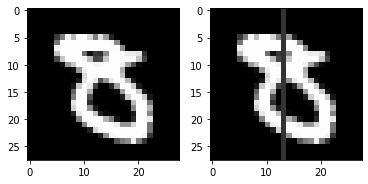

In [358]:
fig,axs=plt.subplots(1,2)
axNoisy,axDenoise = axs


axNoisy.imshow(noisy_img)
axDenoise.imshow(noisy_img_rotate_back)
plt.show()